### Redes Neurais Artificiais
### Professor Ciniro Nametala - IFMG

## Classificação de expressões faciais com Redes Neurais Convolucionais (CNN)

Neste trabalho vamos construir um classificador de expressões faciais utilizando Redes Neurais Convolucionais (CNN). O projeto é dividido em três etapas principais:

1. **Captura de imagens**: Utilizando a webcam, o aluno captura imagens de dez frutas diferentes (maça, uva, manga, banana, pera, tomate, melao, melancia, mamao, limao )
2. **Treinamento da CNN**: Uma rede neural convolucional é treinada para reconhecer dez frutas
3. **Predição ao vivo**: O modelo treinado é utilizado para classificar as frutas em tempo real através da webcam

As imagens são capturadas em escala de cinza com resolução configurável de nxn pixels. O modelo utiliza camadas convolucionais para extrair características das imagens e camadas densas para classificação.

**Classes do modelo:**
- MAÇA 
- UVA
- MANGA
- BANANA
- LIMAO 
- TOMATE 
- ABACAXI
- MELANCIA
- MAMAO
- MELAO


- NEUTRO (quando confiança < 60%)

## 1. Preparação do ambiente

In [3]:
#funcao para deixar o jupyter com celulas preenchendo toda a tela
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [18]:
#cria as pastas para armazenar o dataset e os modelos treinados
import os
os.makedirs("dataset", exist_ok=True)
os.makedirs("models", exist_ok=True)

### 1.1 Importação de pacotes

In [19]:
#para exportar o requeriments
import subprocess
import sys

#bibliotecas para trabalhar com dados e graficos
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate

#bibliotecas do scikit-learn
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

#biblioteca para exportacoes e importacoes de arquivos
from joblib import dump, load

#biblioteca para implementar uma barra de progresso
import progressbar

#biblioteca para tocar sons
import pygame

#bibliotecas para captura de imagens
import cv2
import time
import glob
import shutil

#bibliotecas para deep learning
import tensorflow.keras
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model, to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#bibliotecas para plotar graficos do keras
import pydot as pyd
from tensorflow.keras.utils import plot_model, model_to_dot
tensorflow.keras.utils.pydot = pyd

### 1.2 Verificando versões

In [20]:
print(f"Python version: {sys.version}")
print(f"NumPy version: {np.__version__}")

import tensorflow as tf
print(f"TensorFlow version: {tf.__version__}")

print(f"Pandas version: {pd.__version__}")

import matplotlib
print(f"Matplotlib version: {matplotlib.__version__}")

print(f"Seaborn version: {sns.__version__}")
print(f"OpenCV version: {cv2.__version__}")

Python version: 3.11.14 | packaged by conda-forge | (main, Oct 22 2025, 22:35:28) [MSC v.1944 64 bit (AMD64)]
NumPy version: 2.2.6
TensorFlow version: 2.20.0
Pandas version: 2.3.3
Matplotlib version: 3.10.7
Seaborn version: 0.13.2
OpenCV version: 4.12.0


### 1.3 Checagem de GPU

In [21]:
#verificacao de GPU
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
print(f"TensorFlow encontrou GPUs: {len(gpus) > 0}")
print(f"Dispositivos GPU TensorFlow: {gpus}")

TensorFlow encontrou GPUs: False
Dispositivos GPU TensorFlow: []


## 2. Configurações do experimento

In [27]:
#------------------------------
#CONFIGURACOES DE CAPTURA
#------------------------------

#tempo de captura em segundos
capture_time = 10

#quantidade de fotos por classe
capture_count = 50

#resolucao das imagens (quadradas)
img_size = 128

#tamanho da area de captura na tela (em pixels)
box_size = 400

#realizar nova captura (True) ou usar capturas existentes (False)
#se True, apaga o conteudo da pasta 'captura' e tira novas fotos
#se False, usa as fotos existentes na pasta 'captura'
new_capture = True

#------------------------------
#CONFIGURACOES DE TREINAMENTO
#------------------------------

#gerar um novo modelo ou usar um pronto
new_model = True

#realizar data augmentation (rotacao, zoom, flip)
augmentation_exec = True

#realizar normalizacao de dados (escala 0-1)
normalization_exec = True

#threshold de confianca para classificar como NEUTRO
confidence_threshold = 0.60

#nome do modelo
model_name = 'cnn_expressoes_faciais'

#classes do modelo
class_names = ['maca', 'uva', 'manga', 'banana', 'pera', 'tomate', 'melao', 'melancia', 'mamao', 'limao']
num_classes = len(class_names)

## 3. Captura de imagens

### 3.1 Funções auxiliares de captura

In [23]:
def prepare_capture_folder(base_path='dataset'):
    """prepara a pasta de captura"""
    folder_path = os.path.join(base_path, 'captura')

    #se a pasta existe, apaga e recria
    if os.path.exists(folder_path):
        shutil.rmtree(folder_path)
        print(f'pasta {folder_path} apagada')
    
    os.makedirs(folder_path)
    print(f'pasta {folder_path} criada')
    return folder_path

def capture_images(class_name, num_images, capture_seconds, img_size, box_size, save_path):
    """captura imagens da webcam com countdown e preview"""
    
    #usa o backend AVFoundation no macOS para evitar crash
    if sys.platform == 'darwin':
        cap = cv2.VideoCapture(0, cv2.CAP_AVFOUNDATION)
    else:
        cap = cv2.VideoCapture(0)

    if not cap.isOpened():
        print('erro: nao foi possivel abrir a webcam')
        return False

    #calcula intervalo entre capturas
    interval = capture_seconds / num_images

    print(f'\n=== capturando {class_name.upper()} ===')
    print(f'posicione-se em {class_name.upper()} e pressione SPACE para iniciar...')
    print('pressione Q para cancelar')
    
    window_name = 'Captura'
    cv2.namedWindow(window_name, cv2.WINDOW_AUTOSIZE)

    try:
        #aguarda usuario pressionar space para iniciar
        while True:
            ret, frame = cap.read()
            if not ret:
                break

            #espelha a imagem para facilitar posicionamento
            frame = cv2.flip(frame, 1)

            #adiciona texto de instrucao
            cv2.putText(frame, f'Posicione-se em {class_name.upper()}', (10, 30),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)
            cv2.putText(frame, 'Pressione SPACE para iniciar', (10, 60),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)

            #desenha area de captura
            h, w = frame.shape[:2]
            cx, cy = w // 2, h // 2
            cv2.rectangle(frame, (cx - box_size//2, cy - box_size//2),
                        (cx + box_size//2, cy + box_size//2), (0, 255, 0), 2)

            cv2.imshow(window_name, frame)

            key = cv2.waitKey(1) & 0xFF
            if key == ord(' '):
                break
            elif key == ord('q'):
                cap.release()
                cv2.destroyWindow(window_name)
                cv2.waitKey(1)
                return False

        #inicia captura com countdown
        start_time = time.time()
        images_captured = 0
        last_capture_time = 0

        while images_captured < num_images:
            ret, frame = cap.read()
            if not ret:
                break

            #espelha a imagem
            frame = cv2.flip(frame, 1)

            elapsed = time.time() - start_time
            remaining = max(0, capture_seconds - elapsed)

            #desenha area de captura
            h, w = frame.shape[:2]
            cx, cy = w // 2, h // 2
            cv2.rectangle(frame, (cx - box_size//2, cy - box_size//2),
                        (cx + box_size//2, cy + box_size//2), (0, 0, 255), 2)

            #adiciona countdown e contador de fotos
            cv2.putText(frame, f'Tempo: {remaining:.1f}s', (10, 30),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
            cv2.putText(frame, f'Fotos: {images_captured}/{num_images}', (10, 60),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
            cv2.putText(frame, f'{class_name.upper()}', (10, 90),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)

            cv2.imshow(window_name, frame)

            #captura imagem no intervalo correto
            if elapsed - last_capture_time >= interval:
                #extrai regiao de interesse (ROI)
                roi = frame[cy - box_size//2:cy + box_size//2,
                            cx - box_size//2:cx + box_size//2]

                #converte para escala de cinza
                roi_gray = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)

                #redimensiona para tamanho desejado
                roi_resized = cv2.resize(roi_gray, (img_size, img_size))

                #salva imagem
                filename = os.path.join(save_path, f'{class_name}_{images_captured + 1:03d}.jpg')
                cv2.imwrite(filename, roi_resized)

                images_captured += 1
                last_capture_time = elapsed

            if cv2.waitKey(1) & 0xFF == ord('q'):
                break

            if elapsed >= capture_seconds and images_captured >= num_images:
                break

    finally:
        #libera a camera e fecha a janela de forma segura
        cap.release()
        cv2.destroyWindow(window_name)
        #processa eventos pendentes
        for _ in range(10):
            cv2.waitKey(1)
        time.sleep(0.5)

    print(f'{images_captured} imagens de {class_name.upper()} capturadas')
    return True

### 3.2 Execução da captura

In [25]:
#executa captura se new_capture=True
if new_capture:
    capture_path = prepare_capture_folder()
    
    print('\n' + '='*50)
    print('INICIANDO CAPTURA DE IMAGENS')
    print('='*50)
    print(f'tempo por classe: {capture_time} segundos')
    print(f'fotos por classe: {capture_count}')
    print(f'area de captura: {box_size}x{box_size} pixels')
    print(f'resolucao final: {img_size}x{img_size} pixels (escala de cinza)')
    print('='*50)
    
    frutas = ['maca', 'uva', 'manga', 'banana', 'pera', 'tomate', 'melao', 'melancia', 'mamao', 'limao']
    #captura cada classe
    for class_name in frutas:
        success = capture_images(class_name, capture_count, capture_time, img_size, box_size, capture_path)
        if not success:
            print(f'captura de {class_name} cancelada')
            break
        time.sleep(1)  #pequena pausa entre capturas
    
    print('\n' + '='*50)
    print('CAPTURA FINALIZADA')
    print('='*50)
else:
    capture_path = os.path.join('dataset', 'captura')
    if os.path.exists(capture_path):
        print(f'usando dataset existente: {capture_path}')
    else:
        print(f'erro: pasta {capture_path} nao encontrada')
        print('defina new_capture=True para criar uma nova captura')

pasta dataset\captura apagada
pasta dataset\captura criada

INICIANDO CAPTURA DE IMAGENS
tempo por classe: 10 segundos
fotos por classe: 50
area de captura: 400x400 pixels
resolucao final: 128x128 pixels (escala de cinza)

=== capturando MACA ===
posicione-se em MACA e pressione SPACE para iniciar...
pressione Q para cancelar
50 imagens de MACA capturadas

=== capturando UVA ===
posicione-se em UVA e pressione SPACE para iniciar...
pressione Q para cancelar
50 imagens de UVA capturadas

=== capturando MANGA ===
posicione-se em MANGA e pressione SPACE para iniciar...
pressione Q para cancelar
50 imagens de MANGA capturadas

=== capturando BANANA ===
posicione-se em BANANA e pressione SPACE para iniciar...
pressione Q para cancelar
50 imagens de BANANA capturadas

=== capturando PERA ===
posicione-se em PERA e pressione SPACE para iniciar...
pressione Q para cancelar
50 imagens de PERA capturadas

=== capturando TOMATE ===
posicione-se em TOMATE e pressione SPACE para iniciar...
pression

## 4. Análise de dados

### 4.1 Carregamento das imagens

In [28]:
def load_images(folder_path, class_names, img_size):
    """carrega imagens e retorna arrays de dados e rotulos"""
    images = []
    labels = []
    
    for idx, class_name in enumerate(class_names):
        pattern = os.path.join(folder_path, f'{class_name.lower()}_*.jpg')
        files = glob.glob(pattern)
        
        print(f'{class_name}: {len(files)} imagens encontradas')
        
        for file in files:
            img = cv2.imread(file, cv2.IMREAD_GRAYSCALE)
            if img is not None:
                img = cv2.resize(img, (img_size, img_size))
                images.append(img)
                labels.append(idx)
    
    return np.array(images), np.array(labels)

#carrega as imagens
capture_path = os.path.join('dataset', 'captura')
x_data, y_data = load_images(capture_path, class_names, img_size)

print(f'\ntotal de imagens: {len(x_data)}')
print(f'shape dos dados: {x_data.shape}')
print(f'shape dos rotulos: {y_data.shape}')

maca: 50 imagens encontradas
uva: 50 imagens encontradas
manga: 50 imagens encontradas
banana: 50 imagens encontradas
pera: 50 imagens encontradas
tomate: 50 imagens encontradas
melao: 50 imagens encontradas
melancia: 50 imagens encontradas
mamao: 50 imagens encontradas
limao: 50 imagens encontradas

total de imagens: 500
shape dos dados: (500, 128, 128)
shape dos rotulos: (500,)


### 4.2 Visualização das amostras

IndexError: index 3 is out of bounds for axis 0 with size 3

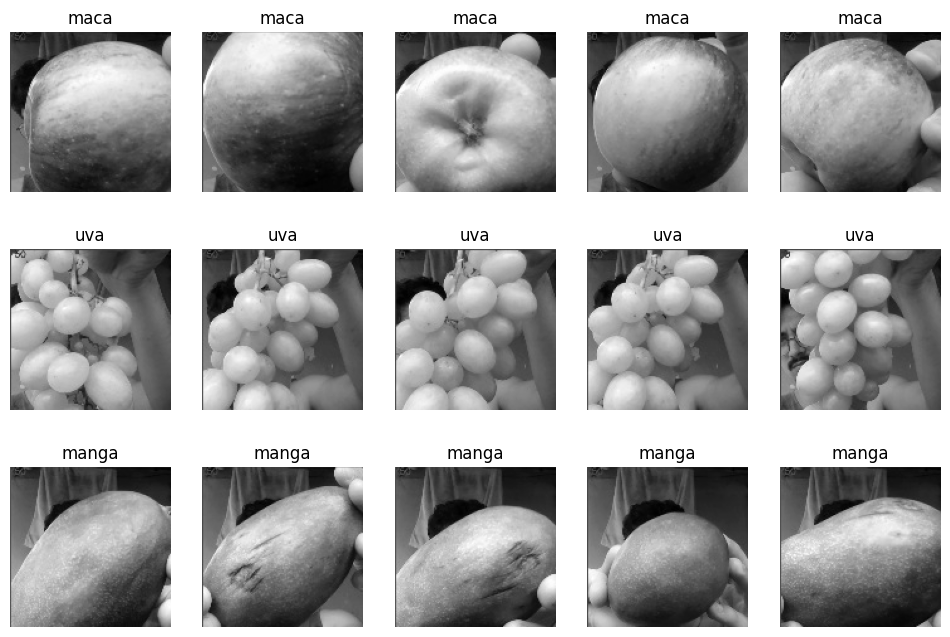

In [29]:
#visualiza algumas amostras de cada classe
fig, axs = plt.subplots(3, 5, figsize=(12, 8))

for i, class_name in enumerate(class_names):
    class_indices = np.where(y_data == i)[0]
    sample_indices = np.random.choice(class_indices, min(5, len(class_indices)), replace=False)
    
    for j, idx in enumerate(sample_indices):
        axs[i, j].imshow(x_data[idx], cmap='gray')
        axs[i, j].set_title(f'{class_name}')
        axs[i, j].axis('off')

plt.tight_layout()
plt.show()

### 4.3 Sumarização estatística

In [30]:
def sumarizacao(x_data, y_data, class_names):
    stats = []

    for idx, class_name in enumerate(class_names):
        class_data = x_data[y_data == idx]
        
        count = len(class_data)
        mean_pixel = round(np.mean(class_data), 2)
        std_pixel = round(np.std(class_data), 2)
        min_pixel = round(np.min(class_data), 2)
        max_pixel = round(np.max(class_data), 2)
        
        stats.append([class_name, count, mean_pixel, std_pixel, min_pixel, max_pixel])

    headers = ['Classe', 'Quantidade', 'Média Pixel', 'Desvio Padrão', 'Mínimo', 'Máximo']

    table = tabulate(stats, headers, tablefmt="pipe")
    print(table)

sumarizacao(x_data, y_data, class_names)

| Classe   |   Quantidade |   Média Pixel |   Desvio Padrão |   Mínimo |   Máximo |
|:---------|-------------:|--------------:|----------------:|---------:|---------:|
| maca     |           50 |        125.85 |           62.65 |        6 |      255 |
| uva      |           50 |        128.35 |           47.68 |        8 |      245 |
| manga    |           50 |        111.41 |           55.22 |        5 |      255 |
| banana   |           50 |        145.91 |           62.42 |        2 |      255 |
| pera     |           50 |        109.47 |           59.96 |        2 |      245 |
| tomate   |           50 |        125.54 |           54.53 |        2 |      255 |
| melao    |           50 |        141.06 |           58.52 |        0 |      255 |
| melancia |           50 |        115.17 |           48.35 |        2 |      255 |
| mamao    |           50 |        128.93 |           57.52 |        5 |      255 |
| limao    |           50 |        123.69 |           56.07 |        1 |    

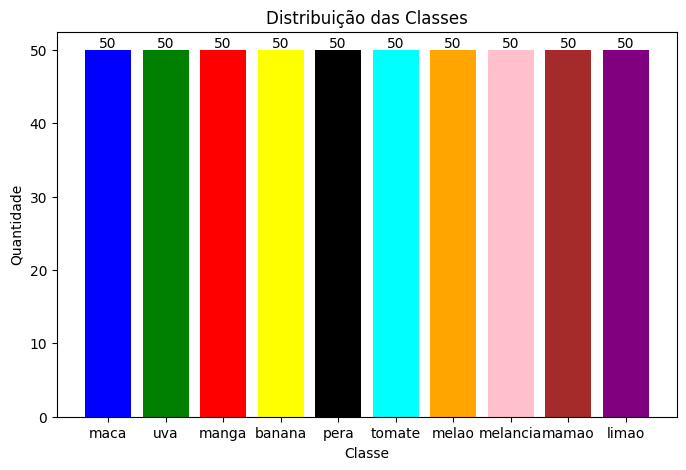

In [33]:
#distribuicao das classes
unique, counts = np.unique(y_data, return_counts=True)

plt.figure(figsize=(8, 5))
plt.bar([class_names[i] for i in unique], counts, color=['blue', 'green', 'red', 'yellow', 'black', 'cyan', 'orange', 'pink', 'brown', 'purple'])
plt.xlabel('Classe')
plt.ylabel('Quantidade')
plt.title('Distribuição das Classes')

for i, count in enumerate(counts):
    plt.text(i, count, str(count), ha='center', va='bottom')

plt.show()

### 4.4 Pré-processamento dos dados

In [34]:
#adiciona dimensao do canal (escala de cinza = 1 canal)
x_data = x_data.reshape(x_data.shape[0], img_size, img_size, 1)

#normalizacao (escala 0-1)
if normalization_exec:
    x_data = x_data.astype('float32') / 255.0
    print('dados normalizados para escala [0, 1]')

#converte rotulos para one-hot encoding
y_data_cat = to_categorical(y_data, num_classes)

print(f'shape dos dados: {x_data.shape}')
print(f'shape dos rotulos (one-hot): {y_data_cat.shape}')

dados normalizados para escala [0, 1]
shape dos dados: (500, 128, 128, 1)
shape dos rotulos (one-hot): (500, 10)


## 5. Separação dos conjuntos de dados (treino, validação e teste)

In [35]:
#separa treino+validacao e teste
x_train_val, x_test, y_train_val, y_test = train_test_split(
    x_data, y_data_cat, test_size=0.2, shuffle=True, random_state=42, stratify=y_data_cat
)

#separa treino e validacao
x_train, x_val, y_train, y_val = train_test_split(
    x_train_val, y_train_val, test_size=0.25, shuffle=True, random_state=42, stratify=y_train_val
)

print(f'x_train shape: {x_train.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'x_val shape: {x_val.shape}')
print(f'y_val shape: {y_val.shape}')
print(f'x_test shape: {x_test.shape}')
print(f'y_test shape: {y_test.shape}')

x_train shape: (300, 128, 128, 1)
y_train shape: (300, 10)
x_val shape: (100, 128, 128, 1)
y_val shape: (100, 10)
x_test shape: (100, 128, 128, 1)
y_test shape: (100, 10)


### 5.1 Data Augmentation (opcional)

data augmentation configurado


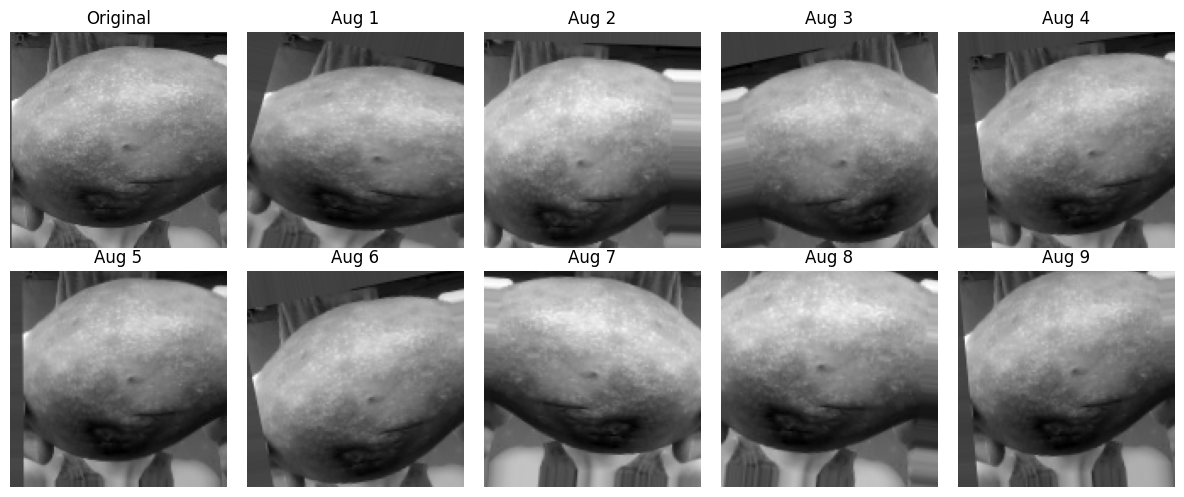

In [36]:
#configura data augmentation
if augmentation_exec:
    datagen = ImageDataGenerator(
        rotation_range=15,
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        fill_mode='nearest'
    )
    datagen.fit(x_train)
    print('data augmentation configurado')
    
    #visualiza exemplos de augmentation
    fig, axs = plt.subplots(2, 5, figsize=(12, 5))
    sample_img = x_train[0:1]
    
    axs[0, 0].imshow(sample_img[0].reshape(img_size, img_size), cmap='gray')
    axs[0, 0].set_title('Original')
    axs[0, 0].axis('off')
    
    for i, batch in enumerate(datagen.flow(sample_img, batch_size=1)):
        if i >= 9:
            break
        row = (i + 1) // 5
        col = (i + 1) % 5
        axs[row, col].imshow(batch[0].reshape(img_size, img_size), cmap='gray')
        axs[row, col].set_title(f'Aug {i+1}')
        axs[row, col].axis('off')
    
    plt.tight_layout()
    plt.show()
else:
    datagen = None
    print('data augmentation desativado')

## 6. Treinamento do modelo

### 6.1 Construção do modelo

In [37]:
#empilhamento de camadas para construir uma CNN

act_function = 'relu'
act_function_out = 'softmax'
drop = 0.25
initializer = tensorflow.keras.initializers.HeNormal()

#entrada
inputs = Input(shape=(img_size, img_size, 1), dtype='float32', name='input')

#bloco convolucional 1
conv1 = Conv2D(32, (3, 3), activation=act_function, padding='same', kernel_initializer=initializer)(inputs)
conv1 = BatchNormalization()(conv1)
conv1 = Conv2D(32, (3, 3), activation=act_function, padding='same', kernel_initializer=initializer)(conv1)
conv1 = BatchNormalization()(conv1)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
drop1 = Dropout(drop)(pool1)

#bloco convolucional 2
conv2 = Conv2D(64, (3, 3), activation=act_function, padding='same', kernel_initializer=initializer)(drop1)
conv2 = BatchNormalization()(conv2)
conv2 = Conv2D(64, (3, 3), activation=act_function, padding='same', kernel_initializer=initializer)(conv2)
conv2 = BatchNormalization()(conv2)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
drop2 = Dropout(drop)(pool2)

#bloco convolucional 3
conv3 = Conv2D(128, (3, 3), activation=act_function, padding='same', kernel_initializer=initializer)(drop2)
conv3 = BatchNormalization()(conv3)
conv3 = Conv2D(128, (3, 3), activation=act_function, padding='same', kernel_initializer=initializer)(conv3)
conv3 = BatchNormalization()(conv3)
pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
drop3 = Dropout(drop)(pool3)

#camadas densas
flat = Flatten()(drop3)
dense1 = Dense(256, activation=act_function, kernel_initializer=initializer)(flat)
dense1 = BatchNormalization()(dense1)
drop4 = Dropout(0.5)(dense1)

#saida
outputs = Dense(num_classes, activation=act_function_out, name='output')(drop4)

#geracao do modelo
cnn_model = Model(inputs, outputs, name=model_name)

### 6.2 Inspecionando o modelo

In [38]:
cnn_model.summary()

Model: "cnn_expressoes_faciais"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 128, 128, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 128, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 64, 64, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 32, 32, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     8,388,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 256)            │         1,02

 Total params: 8,680,682 (33.11 MB)

 Trainable params: 8,679,274 (33.11 MB)

 Non-trainable params: 1,408 (5.50 KB)

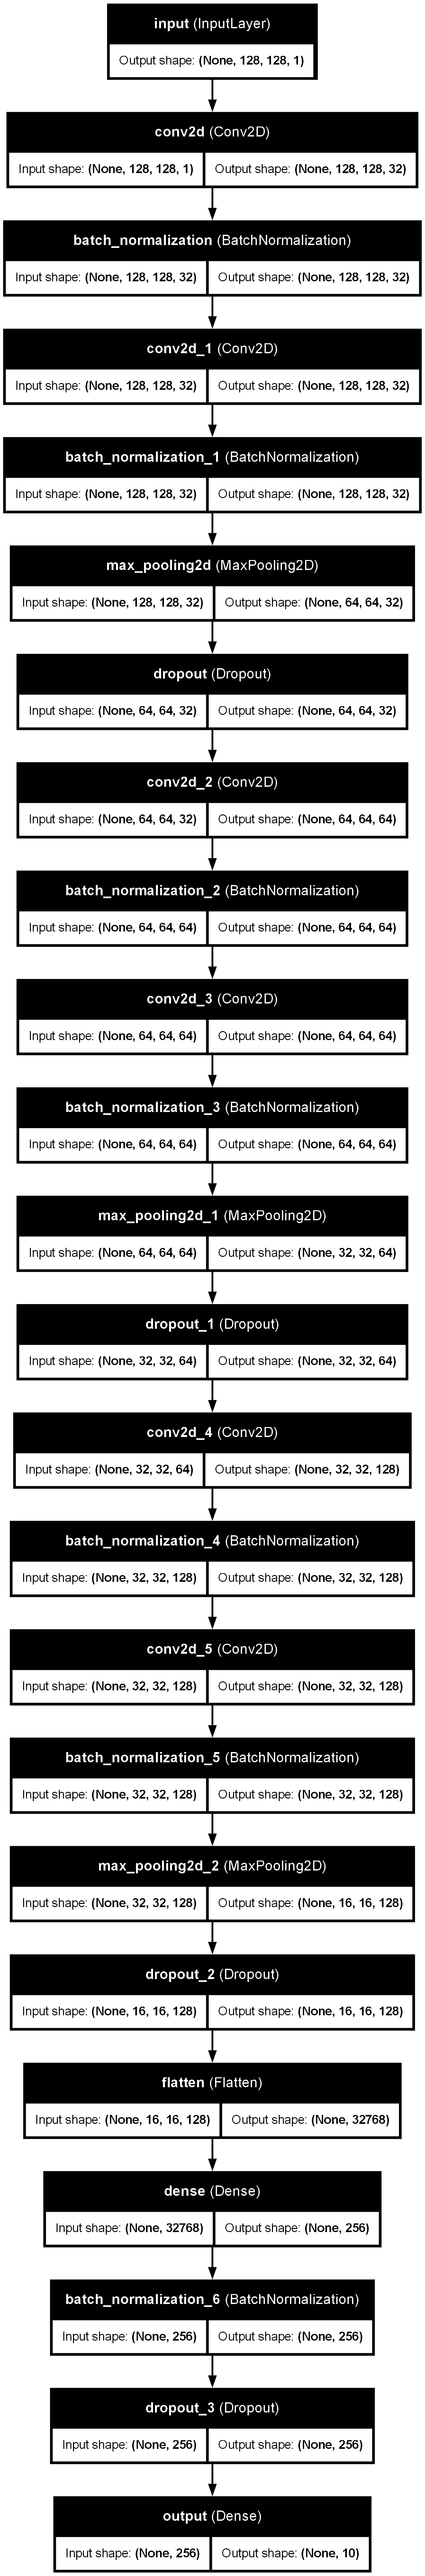

In [39]:
plot_model(cnn_model, show_shapes=True, show_layer_names=True, rankdir="TB")

In [40]:
print('x_train type:', type(x_train))
print('y_train type:', type(y_train))
print('x_train dtype:', x_train.dtype)
print('y_train dtype:', y_train.dtype)
print('x_train shape:', x_train.shape)
print('y_train shape:', y_train.shape)

x_train type: <class 'numpy.ndarray'>
y_train type: <class 'numpy.ndarray'>
x_train dtype: float32
y_train dtype: float64
x_train shape: (300, 128, 128, 1)
y_train shape: (300, 10)


### 6.3 Otimização do modelo

In [41]:
if new_model:
    
    opt = Adam(learning_rate=0.001)
    
    cnn_model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    
    cp = ModelCheckpoint(
        filepath='models/best_model.weights.h5',
        save_weights_only=True,
        monitor='val_loss',
        mode='min',
        save_best_only=True
    )
    
    es = EarlyStopping(monitor='' \
    '', mode='min', patience=80, restore_best_weights=True)
    
    if augmentation_exec and datagen is not None:
        #treina com data augmentation
        history = cnn_model.fit(
            datagen.flow(x_train, y_train, batch_size=8),
            validation_data=(x_val, y_val),
            epochs=300,
            verbose=1,
            callbacks=[es, cp],
            steps_per_epoch=len(x_train) // 8
        )
    else:
        #treina sem data augmentation
        history = cnn_model.fit(
            x_train, y_train,
            validation_data=(x_val, y_val),
            epochs=300,
            verbose=1,
            callbacks=[es, cp],
            batch_size=8,
            shuffle=True
        )
    
    np.save('models/history_model.npy', history.history)
    cnn_model.load_weights('models/best_model.weights.h5')
    cnn_model.save('models/' + model_name + '.h5')
    
else:
    cnn_model = load_model('models/' + model_name + '.h5')

Epoch 1/300
37/37 ━━━━━━━━━━━━━━━━━━━━ 24s 394ms/step - accuracy: 0.3938 - loss: 2.0118 - val_accuracy: 0.1400 - val_loss: 4.8671
Epoch 2/300
 1/37 ━━━━━━━━━━━━━━━━━━━━ 15s 433ms/step - accuracy: 0.2500 - loss: 2.4713

c:\Users\User\.conda\envs\redesneurais\Lib\site-packages\keras\src\trainers\epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.2500 - loss: 2.4713 - val_accuracy: 0.1500 - val_loss: 4.8854
Epoch 3/300
37/37 ━━━━━━━━━━━━━━━━━━━━ 14s 387ms/step - accuracy: 0.5788 - loss: 1.4213 - val_accuracy: 0.0600 - val_loss: 4.6114
Epoch 4/300
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.6250 - loss: 2.2264 - val_accuracy: 0.0700 - val_loss: 4.6268
Epoch 5/300
37/37 ━━━━━━━━━━━━━━━━━━━━ 14s 381ms/step - accuracy: 0.5479 - loss: 1.3381 - val_accuracy: 0.1100 - val_loss: 4.4872
Epoch 6/300
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.7500 - loss: 0.8185 - val_accuracy: 0.1300 - val_loss: 4.5284
Epoch 7/300
37/37 ━━━━━━━━━━━━━━━━━━━━ 13s 360ms/step - accuracy: 0.6233 - loss: 1.1502 - val_accuracy: 0.1500 - val_loss: 5.8766
Epoch 8/300
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.3750 - loss: 1.2967 - val_accuracy: 0.1500 - val_loss: 5.7954
Epoch 9/300
37/37 ━━━━━━━━━━━━━━━━━━━━ 14s 365ms/step - accuracy: 0.6952 - loss: 0.8762 - val_accuracy: 0.1700

In [ ]:
#toca um som para avisar que terminou de executar
pygame.mixer.init()
arquivo_mp3 = 'support_files/mario_coin.mp3'

if os.path.exists(arquivo_mp3):
    pygame.mixer.music.load(arquivo_mp3)
    pygame.mixer.music.play()

    while pygame.mixer.music.get_busy():
        continue

print('Sucesso!')

### 6.4 Avaliação do modelo com curva de convergência

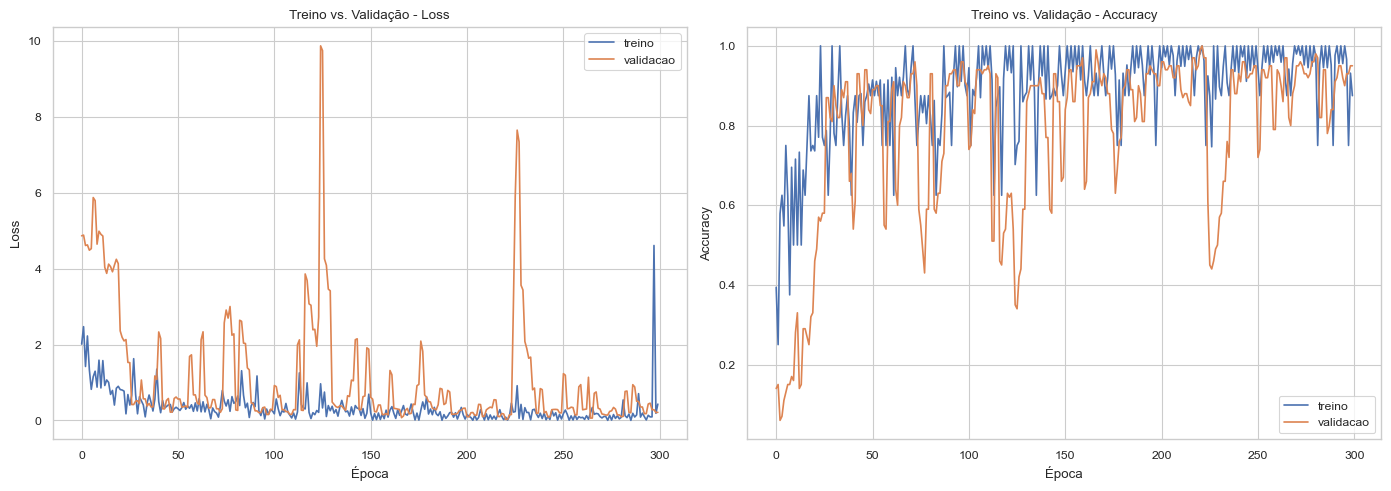

In [42]:
history = np.load('models/history_model.npy', allow_pickle='TRUE').item()

sns.set(rc={'figure.figsize':(12, 6)})
sns.set_style('whitegrid')
sns.set_context('paper')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

#grafico de loss
ax1.plot(history['loss'], label='treino')
ax1.plot(history['val_loss'], label='validacao')
ax1.set_ylabel('Loss')
ax1.set_xlabel('Época')
ax1.set_title('Treino vs. Validação - Loss')
ax1.legend()

#grafico de accuracy
ax2.plot(history['accuracy'], label='treino')
ax2.plot(history['val_accuracy'], label='validacao')
ax2.set_ylabel('Accuracy')
ax2.set_xlabel('Época')
ax2.set_title('Treino vs. Validação - Accuracy')
ax2.legend()

plt.tight_layout()
plt.show()

## 7. Testando as previsões

### 7.1 Gerando as previsões com o modelo treinado

In [43]:
#realiza predicoes no conjunto de teste
y_pred_prob = cnn_model.predict(x_test)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test, axis=1)

print(f'predicoes realizadas: {len(y_pred)}')

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 276ms/step
predicoes realizadas: 100


### 7.2 Calculando a taxa de acerto com base na matriz de confusão

In [44]:
#calculando a matriz de confusao
cm = confusion_matrix(y_true, y_pred)

#calculando a taxa de acerto
accuracy = np.trace(cm) / cm.sum()
accuracy_percent = round(accuracy * 100, 2)
print(f"Taxa de Acerto: {accuracy_percent:.2f}%")

Taxa de Acerto: 98.00%


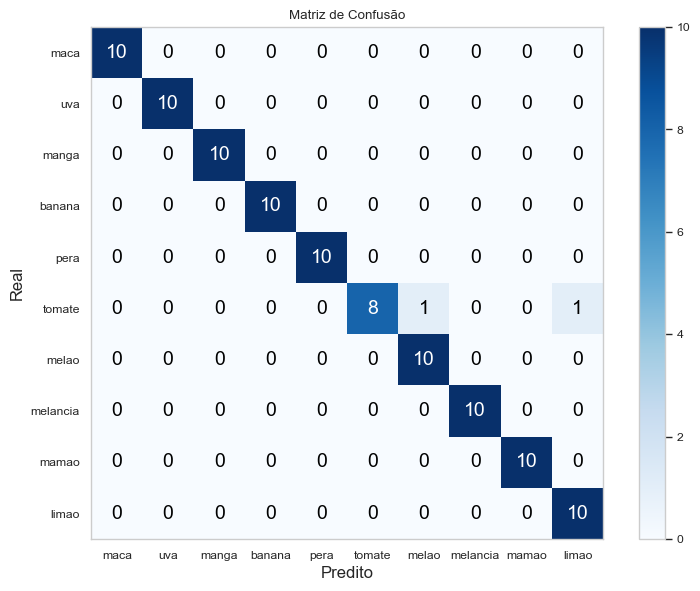

In [45]:
plt.figure(figsize=(8, 6))
plt.grid(False)
plt.imshow(cm, cmap='Blues')

plt.xlabel('Predito', fontsize=12)
plt.ylabel('Real', fontsize=12)
plt.title('Matriz de Confusão')

#adiciona rotulos dos eixos
plt.xticks(range(num_classes), class_names)
plt.yticks(range(num_classes), class_names)

threshold = cm.max() / 2.0
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        color = 'white' if cm[i, j] > threshold else 'black'
        plt.text(j, i, str(cm[i, j]), ha='center', va='center', color=color, fontsize=14)

plt.colorbar()
plt.tight_layout()
plt.show()

### 7.3 Visualização das predições

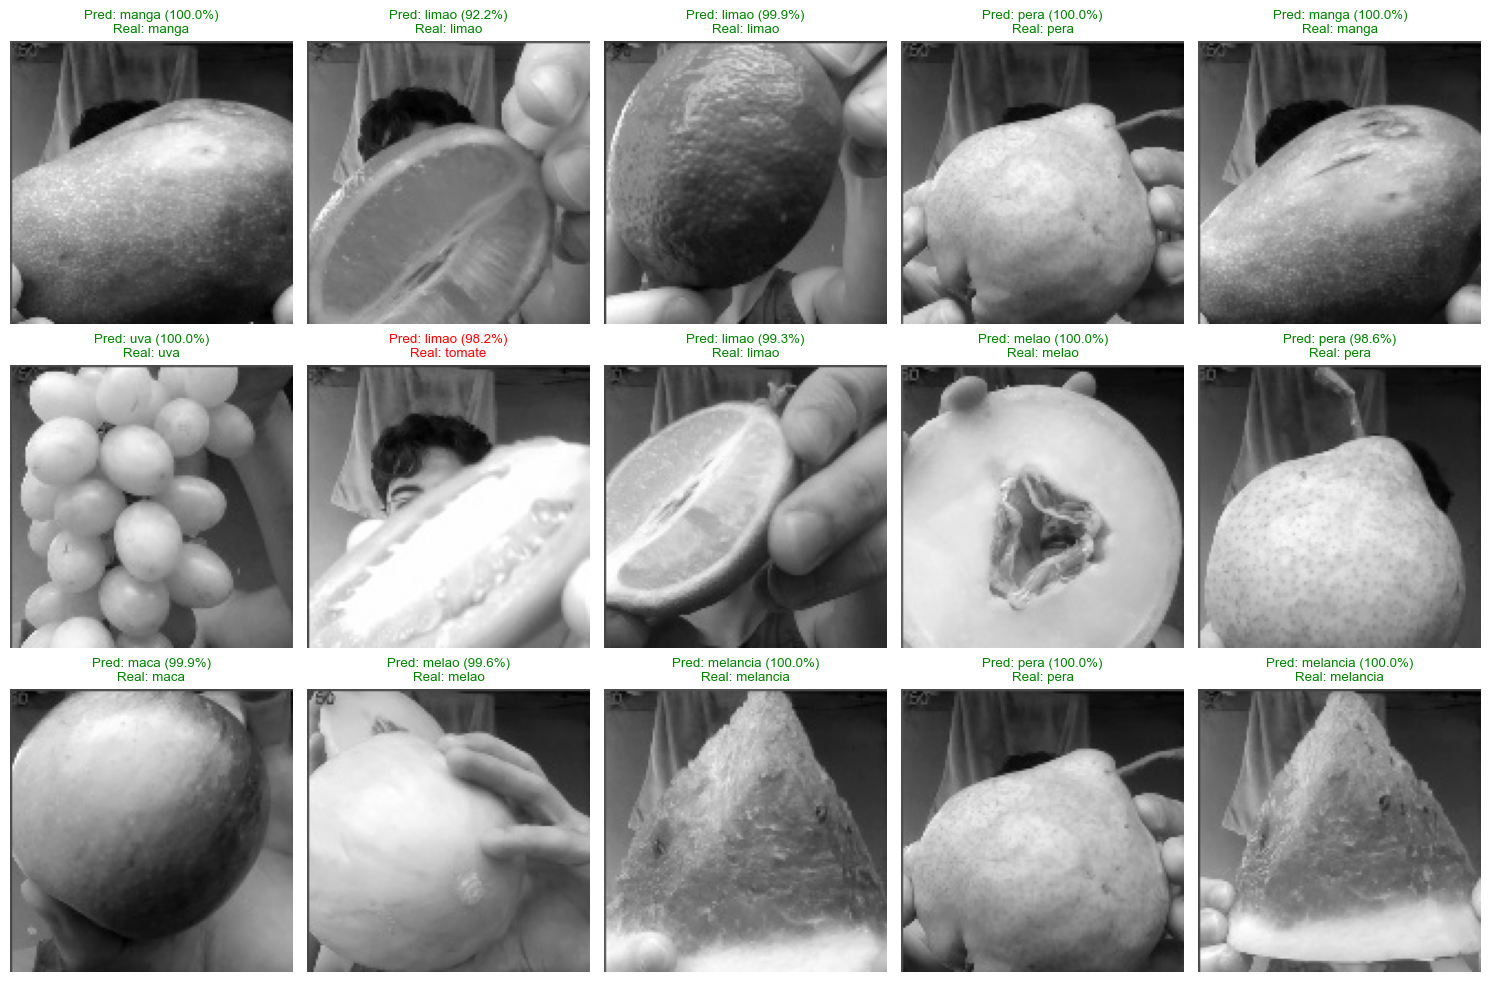

In [46]:
#visualiza algumas predicoes
fig, axs = plt.subplots(3, 5, figsize=(15, 10))

indices = np.random.choice(len(x_test), 15, replace=False)

for i, idx in enumerate(indices):
    row = i // 5
    col = i % 5
    
    axs[row, col].imshow(x_test[idx].reshape(img_size, img_size), cmap='gray')
    
    pred_class = class_names[y_pred[idx]]
    true_class = class_names[y_true[idx]]
    confidence = y_pred_prob[idx][y_pred[idx]] * 100
    
    color = 'green' if y_pred[idx] == y_true[idx] else 'red'
    axs[row, col].set_title(f'Pred: {pred_class} ({confidence:.1f}%)\nReal: {true_class}', color=color)
    axs[row, col].axis('off')

plt.tight_layout()
plt.show()

## 8. Predição ao vivo

### 8.1 Função de predição ao vivo

In [ ]:
def live_prediction(model, class_names, img_size, box_size, confidence_threshold):
    """realiza predicao ao vivo usando a webcam"""
    
    #usa o backend AVFoundation no macOS para evitar crash
    if sys.platform == 'darwin':
        cap = cv2.VideoCapture(0, cv2.CAP_AVFOUNDATION)
    else:
        cap = cv2.VideoCapture(0)
    
    if not cap.isOpened():
        print('erro: nao foi possivel abrir a webcam')
        return
    
    print('=== PREDICAO AO VIVO ===')
    print('posicione-se dentro do quadrado')
    print('pressione Q ou feche a janela para sair')
    print('='*25)
    
    window_name = 'Predicao ao Vivo'
    cv2.namedWindow(window_name, cv2.WINDOW_AUTOSIZE)
    
    try:
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            
            #espelha a imagem
            frame = cv2.flip(frame, 1)
            
            #define area de captura
            h, w = frame.shape[:2]
            cx, cy = w // 2, h // 2
            
            #extrai ROI
            roi = frame[cy - box_size//2:cy + box_size//2, 
                        cx - box_size//2:cx + box_size//2]
            
            #preprocessa para o modelo
            roi_gray = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
            roi_resized = cv2.resize(roi_gray, (img_size, img_size))
            roi_normalized = roi_resized.astype('float32') / 255.0
            roi_input = roi_normalized.reshape(1, img_size, img_size, 1)
            
            #realiza predicao
            prediction = model.predict(roi_input, verbose=0)
            pred_class = np.argmax(prediction)
            confidence = prediction[0][pred_class]
            
            #determina o texto a exibir
            if confidence >= confidence_threshold:
                label = f'{class_names[pred_class]} ({confidence*100:.1f}%)'
                color = (0, 255, 0)  #verde
            else:
                label = f'NADA ({confidence*100:.1f}%)'
                color = (0, 0, 255)  #vermelho
            
            #desenha area de captura
            cv2.rectangle(frame, (cx - box_size//2, cy - box_size//2), 
                        (cx + box_size//2, cy + box_size//2), color, 2)
            
            #adiciona texto com o resultado
            cv2.putText(frame, label, (cx - box_size//2, cy - box_size//2 - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 1, color, 2)
            
            #mostra barra de confianca
            bar_width = int(box_size * confidence)
            cv2.rectangle(frame, (cx - box_size//2, cy + box_size//2 + 10),
                        (cx - box_size//2 + bar_width, cy + box_size//2 + 30), color, -1)
            cv2.rectangle(frame, (cx - box_size//2, cy + box_size//2 + 10),
                        (cx + box_size//2, cy + box_size//2 + 30), color, 2)
            
            #adiciona instrucoes
            cv2.putText(frame, 'Pressione Q para sair', (10, 30),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)
            
            cv2.imshow(window_name, frame)
            
            #verifica se usuario quer sair
            key = cv2.waitKey(1) & 0xFF
            if key == ord('q'):
                break
            
            #verifica se janela foi fechada
            try:
                if cv2.getWindowProperty(window_name, cv2.WND_PROP_VISIBLE) < 1:
                    break
            except:
                break
    
    finally:
        #libera a camera e fecha a janela de forma segura
        cap.release()
        cv2.destroyWindow(window_name)
        #processa eventos pendentes
        for _ in range(10):
            cv2.waitKey(1)
        time.sleep(0.5)
    
    print('predicao ao vivo finalizada')

### 8.2 Executar predição ao vivo

In [ ]:
#carrega o modelo se necessario
if 'cnn_model' not in dir() or cnn_model is None:
    cnn_model = load_model('models/' + model_name + '.h5')
    print('modelo carregado')

#inicia predicao ao vivo
live_prediction(cnn_model, class_names, img_size, box_size, confidence_threshold)